# Contents

### 1 Import Packages

### 2 Load Data

#### 2.1 Checking for NULLs

#### 2.2 Handling NULLs

#### 2.3 Handling dates

### 3 Handling Data

#### 3.1 Set date as index

#### 3.2 Resample Data

#### 3.3 Train/Test Split

### 4 Checking Data

#### 4.1 Visualizing the time series

#### 4.2 Stationarity Test

#### 4.3 Differencing

#### 4.4 Granger Causality Test

### 5 VAR - Vector Auto Regression

#### 5.1 Forecasting on Test data index

#### 5.2 Invert Differencing

#### 5.3 Plot the forecast and actual values

#### 5.4 Evaluate the forecasts

### 1 Import Packages

In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.statespace.varmax import VARMAX

from pylab import rcParams

import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

%config Completer.use_jedi = False

### 2 Load Data

In [2]:
dataset = pd.read_csv('C:\\Users\\Sarat\\Desktop\\Time Series Forecasting\\data\\Beijing_AirQuality_PM2.5.csv')

In [3]:
dataset.drop(columns=['No'], inplace=True)

#### 2.1 Checking for NULLs

In [4]:
dataset.isna().sum()

year        0
month       0
day         0
hour        0
pm2.5    2067
DEWP        0
TEMP        0
PRES        0
cbwd        0
Iws         0
Is          0
Ir          0
dtype: int64

#### 2.2 Handling NULLs

#### 2.3 Handling dates

In [5]:
dataset['Date'] = pd.to_datetime(dataset[['year', 'month', 'day', 'hour']])

In [6]:
dataset.drop(columns=['year', 'month', 'day', 'hour'], inplace = True)

In [7]:
dataset.drop(columns=['Iws', 'Is', 'Ir'], inplace = True)

### 3 Handling Data

#### 3.1 Set date as index

In [8]:
dataset_2 = dataset.set_index('Date')

#### 3.2 Resample Data

In [9]:
dataset_3 = dataset_2.resample('D').mean()

In [10]:
dataset_3.isnull().sum()

pm2.5    37
DEWP      0
TEMP      0
PRES      0
dtype: int64

In [11]:
dataset_3.replace(np.nan, 0, inplace=True)

#### 3.3 Train/Test Split

In [12]:
datasetTrain = dataset_3[:'2014-06-30']

datasetTest = dataset_3['2014-07-01':]

### 4 Checking Data

#### 4.1 Visualizing the time series

In [13]:
def adf_test(ts, signif=0.05):
    dftest = adfuller(ts, autolag='AIC')
    adf = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# Lags','# Observations'])
    
    for key,value in dftest[4].items():
       adf['Critical Value (%s)'%key] = value
    print (adf)
    
    p = adf['p-value']
    if p <= signif:
        print(f" Series is Stationary")
    else:
        print(f" Series is Non-Stationary")

In [14]:
for each in datasetTrain.columns:
    
    print('Stationarity Test for ', each, 'column:\n')
    adf_test(datasetTrain[[each]])
    print('\n\n')

Stationarity Test for  pm2.5 column:

Test Statistic           -21.822332
p-value                    0.000000
# Lags                     1.000000
# Observations          1640.000000
Critical Value (1%)       -3.434344
Critical Value (5%)       -2.863304
Critical Value (10%)      -2.567709
dtype: float64
 Series is Stationary



Stationarity Test for  DEWP column:

Test Statistic            -2.185341
p-value                    0.211609
# Lags                    11.000000
# Observations          1630.000000
Critical Value (1%)       -3.434368
Critical Value (5%)       -2.863315
Critical Value (10%)      -2.567715
dtype: float64
 Series is Non-Stationary



Stationarity Test for  TEMP column:

Test Statistic            -2.073376
p-value                    0.255354
# Lags                     8.000000
# Observations          1633.000000
Critical Value (1%)       -3.434361
Critical Value (5%)       -2.863312
Critical Value (10%)      -2.567713
dtype: float64
 Series is Non-Stationary



Stat

#### 4.2 Stationarity Test

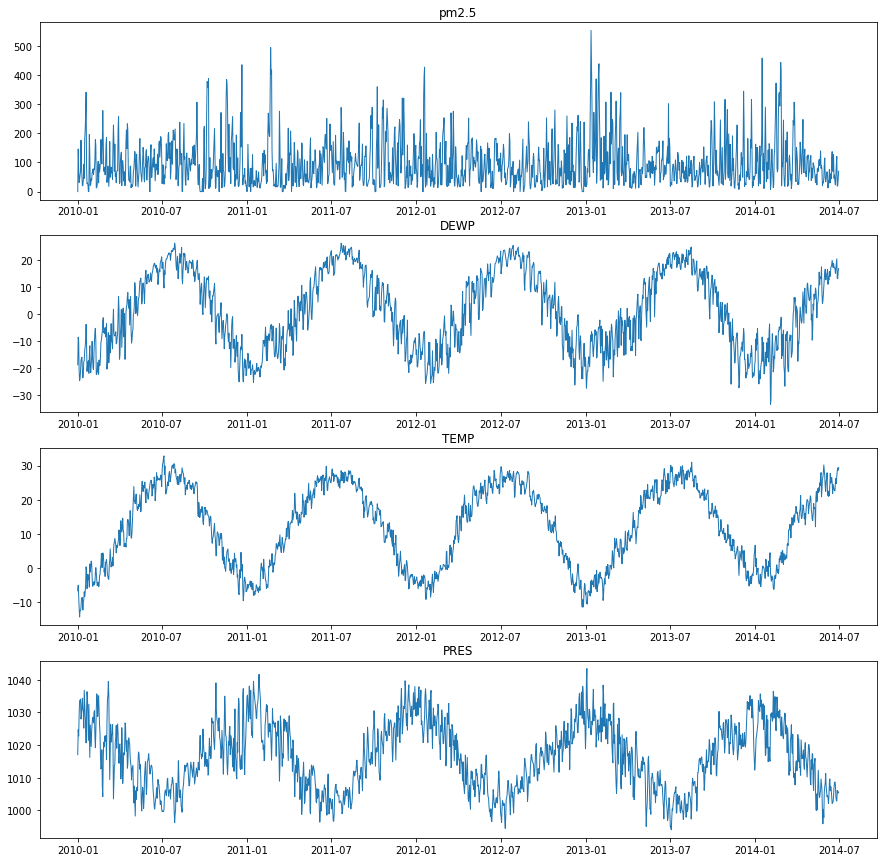

In [15]:
plt.figure(figsize=(15,15))
count = 1

for each in datasetTrain.columns:
    
    plt.subplot(4,1, count)
    plt.title(each)
    plt.plot(datasetTrain[[each]], linewidth = 1)
    count += 1

plt.show()

#### 4.3 Differencing

In [16]:
datasetTrain_diff = datasetTrain.diff()

In [17]:
datasetTrain_diff.dropna(how='all', inplace = True)

In [18]:
datasetTrain_diff

,pm2.5,DEWP,TEMP,PRES
Date,,,,
2010-01-02,145.958333,10.250000,1.625000,7.666667
2010-01-03,-67.125000,-1.625000,-3.416667,-1.958333
2010-01-04,-47.500000,-10.750000,-2.958333,6.500000
2010-01-05,11.125000,-3.708333,-2.958333,4.333333
2010-01-06,13.958333,0.875000,1.916667,0.125000
...,...,...,...,...
2014-06-26,28.166667,1.708333,2.166667,-0.250000
2014-06-27,-102.250000,-7.291667,1.541667,3.250000
2014-06-28,1.541667,0.041667,0.875000,-0.833333


#### 4.4 Granger Causality - Testing if the variables influence each other

In [19]:
maxlag=12
test = 'ssr-chi2test'

In [20]:
def grangers_causality_matrix(X_train, variables, test = 'ssr_chi2test', verbose=False):
    
    dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    
    for c in dataset.columns:
        for r in dataset.index:
            
            test_result = grangercausalitytests(X_train[[r,c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            dataset.loc[r,c] = min_p_value
            
    dataset.columns = [var + '_x' for var in variables]
    dataset.index = [var + '_y' for var in variables]
            
    return dataset

In [21]:
grangers_causality_matrix(datasetTrain_diff, variables = datasetTrain_diff.columns, verbose = True)

Y = pm2.5, X = pm2.5, P Values = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Y = DEWP, X = pm2.5, P Values = [0.0019, 0.0052, 0.0167, 0.0348, 0.1679, 0.2567, 0.4568, 0.6828, 0.5984, 0.7349, 0.6865, 0.6243]
Y = TEMP, X = pm2.5, P Values = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Y = PRES, X = pm2.5, P Values = [0.0002, 0.0848, 0.0512, 0.1573, 0.1616, 0.0248, 0.0803, 0.0488, 0.1221, 0.0951, 0.0495, 0.0904]
Y = pm2.5, X = DEWP, P Values = [0.7505, 0.0071, 0.0713, 0.0744, 0.0617, 0.061, 0.1098, 0.2174, 0.0574, 0.105, 0.0122, 0.0475]
Y = DEWP, X = DEWP, P Values = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Y = TEMP, X = DEWP, P Values = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Y = PRES, X = DEWP, P Values = [0.0005, 0.1207, 0.0007, 0.0499, 0.043, 0.0167, 0.009, 0.0115, 0.0199, 0.0315, 0.0463, 0.0337]
Y = pm2.5, X = TEMP, P Values = [0.0127, 0.1489, 0.2329, 0.9647, 0.1662, 0.0657, 0.6048, 0.6043, 0.6339, 0.7865, 0.047

,pm2.5_x,DEWP_x,TEMP_x,PRES_x
pm2.5_y,1.0000,0.0071,0.0127,0.0
DEWP_y,0.0019,1.0000,0.0000,0.0
TEMP_y,0.0000,0.0000,1.0000,0.0
PRES_y,0.0002,0.0005,0.0000,1.0


### 5 VAR - Vector Auto Regression

In [22]:
testModel = None
testModel = VAR(datasetTrain_diff)

In [23]:
results = testModel.fit(maxlags = 5, ic='aic')

In [24]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 26, May, 2021
Time:                     15:04:47
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    14.7429
Nobs:                     1636.00    HQIC:                   14.5685
Log likelihood:          -21034.4    FPE:                1.91574e+06
AIC:                      14.4656    Det(Omega_mle):     1.82046e+06
--------------------------------------------------------------------
Results for equation pm2.5
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const           -0.002471         1.661337           -0.001           0.999
L1.pm2.5        -0.220804         0.032776           -6.737           0.000
L1.DEWP          1.036534         0.536521            1.932           0.053
L1.T

#### 5.1 Forecasting on Test data index

In [25]:
prediction = results.forecast(results.endog, steps = len(datasetTest))

In [26]:
predictionDF = pd.DataFrame(prediction, columns=datasetTest.columns, index=datasetTest.index)

#### 5.2 Invert Differencing

In [27]:
prediction_values = pd.DataFrame(columns=datasetTest.columns, index=datasetTest.index)

In [28]:
prediction_values['pm2.5'] = np.r_[datasetTrain[-1:]['pm2.5'][0], predictionDF['pm2.5']].cumsum()[1:]
prediction_values['DEWP'] = np.r_[datasetTrain[-1:]['DEWP'][0], predictionDF['DEWP']].cumsum()[1:]
prediction_values['TEMP'] = np.r_[datasetTrain[-1:]['TEMP'][0], predictionDF['TEMP']].cumsum()[1:]
prediction_values['PRES'] = np.r_[datasetTrain[-1:]['PRES'][0], predictionDF['PRES']].cumsum()[1:]

#### 5.3 Plot the forecast and actual values

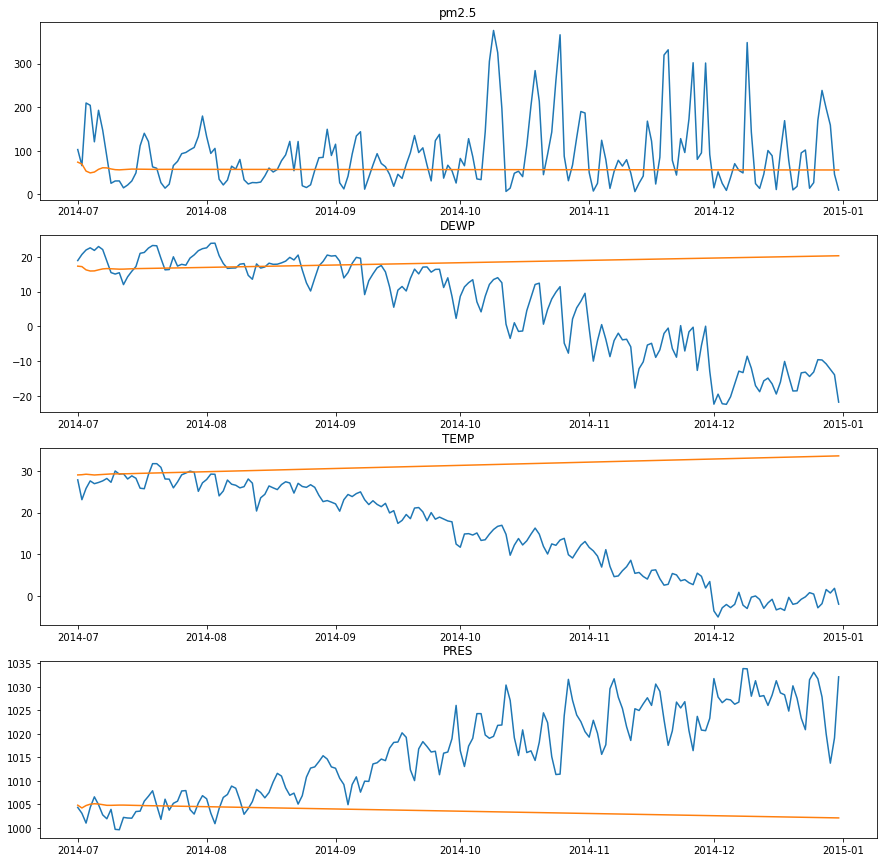

In [29]:
plt.figure(figsize=(15,15))

plt.subplot(4,1,1)
plt.plot(datasetTest['pm2.5'])
plt.plot(prediction_values['pm2.5'])
plt.title('pm2.5')

plt.subplot(4,1,2)
plt.plot(datasetTest['DEWP'])
plt.plot(prediction_values['DEWP'])
plt.title('DEWP')

plt.subplot(4,1,3)
plt.plot(datasetTest['TEMP'])
plt.plot(prediction_values['TEMP'])
plt.title('TEMP')

plt.subplot(4,1,4)
plt.plot(datasetTest['PRES'])
plt.plot(prediction_values['PRES'])
plt.title('PRES')


plt.show()

#### 5.4 Evaluate the forecasts

In [30]:
mae = mean_absolute_error(datasetTest['pm2.5'], prediction_values['pm2.5'])
print('MAE: %.3f' % mae)

mape = mean_absolute_percentage_error(datasetTest['pm2.5'], prediction_values['pm2.5'])
print('MAPE: %.3f' % mape)

MAE: 55.932
MAPE: 0.889


In [31]:
mae = mean_absolute_error(datasetTest['DEWP'], prediction_values['DEWP'])
print('MAE: %.3f' % mae)

mape = mean_absolute_percentage_error(datasetTest['DEWP'], prediction_values['DEWP'])
print('MAPE: %.3f' % mape)

MAE: 13.762
MAPE: 6.095


In [32]:
mae = mean_absolute_error(datasetTest['TEMP'], prediction_values['TEMP'])
print('MAE: %.3f' % mae)

mape = mean_absolute_percentage_error(datasetTest['TEMP'], prediction_values['TEMP'])
print('MAPE: %.3f' % mape)

MAE: 16.015
MAPE: 11.451


In [33]:
mae = mean_absolute_error(datasetTest['PRES'], prediction_values['PRES'])
print('MAE: %.3f' % mae)

mape = mean_absolute_percentage_error(datasetTest['PRES'], prediction_values['PRES'])
print('MAPE: %.3f' % mape)

MAE: 13.273
MAPE: 0.013
